#**TP5 SES Groupe 1**

In [54]:
!pip install geemap --upgrade

In [55]:
# Installation de l'API Google Earth Engine
!pip install earthengine-api --upgrade

# Installation de la bibliothèque de visualisation interactive
!pip install geemap

In [4]:
import ee

# Lance la procédure d'authentification
ee.Authenticate()

True

In [5]:
# -------------------------------------------------------------------------
# CONFIGURATION DU PROJET
# -------------------------------------------------------------------------
NOM_DU_PROJET = 'travaux-pratique-478314'

# Initialisation de la connexion GEE
ee.Initialize(project=NOM_DU_PROJET)

# Importation de geemap pour la carte interactive
import geemap

In [18]:
# =========================================================================
# ANALYSE DE L'ÉTALEMENT URBAIN EN TANZANIE (2017-2022)
# Version optimisée avec calculs régionaux uniquement
# =========================================================================

import ee
import pandas as pd
import numpy as np

# Période d'analyse
ANNEE_DEBUT = 2017
ANNEE_FIN = 2022
T = ANNEE_FIN - ANNEE_DEBUT  # 5 ans

# Assets des limites administratives
GADM_L1_ASSET_ID = 'projects/travaux-pratique-478314/assets/GADM_Tanzanie_ADMIN1'
REGION_COLONNE = 'NAME_1'
GADM_L0_ASSET_ID = 'projects/travaux-pratique-478314/assets/GADM_Tanzanie_ADMIN0'

# Assets d'occupation du sol (6 tuiles par année)
OCCUPATION_2017_ASSETS = [
    'projects/travaux-pratique-478314/assets/Occupation_2017_1',
    'projects/travaux-pratique-478314/assets/Occupation_2017_2',
    'projects/travaux-pratique-478314/assets/Occupation_2017_3',
    'projects/travaux-pratique-478314/assets/Occupation_2017_4',
    'projects/travaux-pratique-478314/assets/Occupation_2017_5',
    'projects/travaux-pratique-478314/assets/Occupation_2017_6'
]

OCCUPATION_2022_ASSETS = [
    'projects/travaux-pratique-478314/assets/Occupation_2022_1',
    'projects/travaux-pratique-478314/assets/Occupation_2022_2',
    'projects/travaux-pratique-478314/assets/Occupation_2022_3',
    'projects/travaux-pratique-478314/assets/Occupation_2022_4',
    'projects/travaux-pratique-478314/assets/Occupation_2022_5',
    'projects/travaux-pratique-478314/assets/Occupation_2022_6'
]

# Assets de population WorldPop
POPULATION_2017_ASSET = 'projects/travaux-pratique-478314/assets/worldpop_Tanzanie_2017'
POPULATION_2022_ASSET = 'projects/travaux-pratique-478314/assets/worldpop_Tanzanie_2022'

# -------------------------------------------------------------------------
# PARAMÈTRES D'ANALYSE
# -------------------------------------------------------------------------

# Classe représentant les zones bâties dans vos rasters d'occupation
CLASSE_BATIE = 7

# Résolution spatiale des données d'occupation du sol (en mètres)
# D'après la vérification : 10m × 10m par pixel
RESOLUTION_OCCUPATION_M = 10
SUPERFICIE_PIXEL_KM2 = (RESOLUTION_OCCUPATION_M ** 2) / 1e6  # = 0.0001 km²

# Échelles de calcul
SCALE_OCCUPATION = 10   # Résolution native des données d'occupation (10m)
SCALE_POPULATION = 100  # Résolution WorldPop (100m)

# Projection UTM pour la Tanzanie
TARGET_CRS = 'EPSG:32735'  # UTM Zone 35S

#FACTEUR_CORRECTION_POP = 1/100  # Diviser par 100

# -------------------------------------------------------------------------
# INITIALISATION DE GOOGLE EARTH ENGINE
# -------------------------------------------------------------------------
ee.Initialize(project=NOM_DU_PROJET)

print("="*80)
print("     ANALYSE DE L'ÉTALEMENT URBAIN - TANZANIE")
print(f"     Période : {ANNEE_DEBUT} - {ANNEE_FIN}")
print("="*80)
print(f"\nParamètres de l'analyse :")
print(f"  • Résolution occupation du sol : {RESOLUTION_OCCUPATION_M}m")
print(f"  • Superficie par pixel : {SUPERFICIE_PIXEL_KM2} km²")
print(f"  • Classe bâtie : {CLASSE_BATIE}")
#print(f"  • Facteur correction population : {FACTEUR_CORRECTION_POP}")
print("="*80 + "\n")

# =========================================================================
# ÉTAPE 1 : CHARGEMENT DES LIMITES ADMINISTRATIVES
# =========================================================================

print("ÉTAPE 1 : Chargement des limites administratives")
print("-" * 80)

# Charger les régions (niveau 1)
admin_regions = ee.FeatureCollection(GADM_L1_ASSET_ID)

# Charger la géométrie nationale (niveau 0)
aoi_national = ee.FeatureCollection(GADM_L0_ASSET_ID).first().geometry()

# Obtenir le nombre de régions
num_regions = admin_regions.size().getInfo()

print(f"✓ Nombre de régions (niveau 1) : {num_regions}")
print(f"✓ Géométrie nationale chargée")
print(f"✓ Projection cible : {TARGET_CRS}\n")

# =========================================================================
# ÉTAPE 2 : PRÉPARATION DES IMAGES D'OCCUPATION DU SOL
# =========================================================================

print("ÉTAPE 2 : Préparation des mosaïques d'occupation du sol")
print("-" * 80)

def create_occupation_mosaic(asset_list, year):
    """
    Crée une mosaïque à partir des tuiles d'occupation du sol.

    Args:
        asset_list: Liste des IDs des assets à mosaïquer
        year: Année des données (pour le nommage)

    Returns:
        Image EE de la mosaïque clippée à l'AOI nationale
    """
    images = []

    # Charger chaque tuile
    for i, asset_id in enumerate(asset_list, 1):
        try:
            img = ee.Image(asset_id).select(['b1'])
            images.append(img)
            print(f"  ✓ Tuile {i}/6 chargée")
        except Exception as e:
            print(f"  ✗ Erreur tuile {i}/6 : {str(e)[:50]}")

    if len(images) == 0:
        raise Exception(f"Aucune image chargée pour {year}")

    # Créer la mosaïque
    mosaic = ee.ImageCollection(images).mosaic()

    # Clipper à l'AOI nationale
    mosaic_clipped = mosaic.clip(aoi_national)

    print(f"  → Mosaïque {year} créée ({len(images)}/6 tuiles)")

    return mosaic_clipped

# Créer les mosaïques pour 2017 et 2022
print(f"\nAnnée {ANNEE_DEBUT} :")
occupation_2017 = create_occupation_mosaic(OCCUPATION_2017_ASSETS, ANNEE_DEBUT)

print(f"\nAnnée {ANNEE_FIN} :")
occupation_2022 = create_occupation_mosaic(OCCUPATION_2022_ASSETS, ANNEE_FIN)

print("\n✓ Mosaïques d'occupation créées\n")

# =========================================================================
# ÉTAPE 3 : EXTRACTION DES ZONES BÂTIES
# =========================================================================

print("ÉTAPE 3 : Extraction des zones bâties")
print("-" * 80)

# Avant d'extraire, inspectons la première image pour connaître les valeurs
print("\nInspection des valeurs de classes d'occupation du sol...")
sample_values_2017 = occupation_2017.sample(
    region=aoi_national,
    scale=100,
    numPixels=100,
    geometries=False
).aggregate_array('b1').distinct().sort().getInfo()

print(f"Valeurs uniques trouvées dans les données 2017 : {sample_values_2017}")

def extract_built_area(occupation_image, year):
    """
    Extrait les pixels de la classe bâtie et calcule leur superficie.

    Args:
        occupation_image: Image d'occupation du sol
        year: Année (pour le nommage des bandes)

    Returns:
        Image où chaque pixel bâti = superficie en km²
    """
    # Créer un masque binaire : 1 = bâti, 0 = autre
    built_mask = occupation_image.eq(CLASSE_BATIE)

    # Appliquer le masque (ne garder que les pixels bâtis)
    # Chaque pixel bâti représente SUPERFICIE_PIXEL_KM2 km²
    #built_area = built_mask.selfMask().multiply(SUPERFICIE_PIXEL_KM2)
    built_area = built_mask.multiply(SUPERFICIE_PIXEL_KM2)

    # Renommer la bande
    built_area_named = built_area.rename(f'V_{year}')

    return built_area_named

# Extraire les zones bâties pour les deux années
V_2017 = extract_built_area(occupation_2017, ANNEE_DEBUT)
V_2022 = extract_built_area(occupation_2022, ANNEE_FIN)

print(f"✓ Zones bâties extraites (classe {CLASSE_BATIE})")
print(f"  • Chaque pixel bâti = {SUPERFICIE_PIXEL_KM2} km²\n")

# =========================================================================
# ÉTAPE 4 : PRÉPARATION DES DONNÉES DE POPULATION
# =========================================================================

print("ÉTAPE 4 : Préparation des données de population")
print("-" * 80)

def prepare_population(asset_id, year):
    """
    Charge et prépare les données de population avec correction du facteur.

    WorldPop fournit le nombre d'habitants par pixel de 100m × 100m.
    Vos données semblent être multipliées par 100, donc on applique
    le facteur de correction.

    Args:
        asset_id: ID de l'asset WorldPop
        year: Année (pour le nommage)

    Returns:
        Image de population corrigée
    """
    # Charger l'image
    pop_raw = ee.Image(asset_id).select(['b1'])

    # Appliquer le facteur de correction (diviser par 100)
    #pop_corrected = pop_raw.multiply(FACTEUR_CORRECTION_POP)

    # Clipper et renommer
    pop_final = pop_raw.clip(aoi_national).rename(f'Pop_{year}')

    return pop_final

# Préparer les images de population pour 2017 et 2022
Pop_2017 = prepare_population(POPULATION_2017_ASSET, ANNEE_DEBUT)
Pop_2022 = prepare_population(POPULATION_2022_ASSET, ANNEE_FIN)

print(f"✓ Données de population préparées")
#print(f"  • Facteur de correction appliqué : {FACTEUR_CORRECTION_POP}")
print(f"  • Les valeurs sont maintenant en habitants par pixel (1km)\n")

     ANALYSE DE L'ÉTALEMENT URBAIN - TANZANIE
     Période : 2017 - 2022

Paramètres de l'analyse :
  • Résolution occupation du sol : 10m
  • Superficie par pixel : 0.0001 km²
  • Classe bâtie : 7

ÉTAPE 1 : Chargement des limites administratives
--------------------------------------------------------------------------------
✓ Nombre de régions (niveau 1) : 31
✓ Géométrie nationale chargée
✓ Projection cible : EPSG:32735

ÉTAPE 2 : Préparation des mosaïques d'occupation du sol
--------------------------------------------------------------------------------

Année 2017 :
  ✓ Tuile 1/6 chargée
  ✓ Tuile 2/6 chargée
  ✓ Tuile 3/6 chargée
  ✓ Tuile 4/6 chargée
  ✓ Tuile 5/6 chargée
  ✓ Tuile 6/6 chargée
  → Mosaïque 2017 créée (6/6 tuiles)

Année 2022 :
  ✓ Tuile 1/6 chargée
  ✓ Tuile 2/6 chargée
  ✓ Tuile 3/6 chargée
  ✓ Tuile 4/6 chargée
  ✓ Tuile 5/6 chargée
  ✓ Tuile 6/6 chargée
  → Mosaïque 2022 créée (6/6 tuiles)

✓ Mosaïques d'occupation créées

ÉTAPE 3 : Extraction des zones bâti

In [38]:
# =========================================================================
# ÉTAPE 5 : CALCUL DES STATISTIQUES PAR RÉGION
# =========================================================================

print("ÉTAPE 5 : Calcul des statistiques régionales")
print("-" * 80)
print(f"Traitement de {num_regions} régions...")
#print("(Peut prendre 5-10 minutes selon la taille des régions)\n")

# Convertir la FeatureCollection en liste pour itération
regions_list = admin_regions.toList(admin_regions.size())

# Liste pour stocker les résultats
regions_data = []

# Définir le réducteur (somme)
reducer = ee.Reducer.sum()

# Boucle sur chaque région
for i in range(num_regions):
    # Récupérer la région
    region = ee.Feature(regions_list.get(i))
    region_name = region.get(REGION_COLONNE).getInfo()
    region_geom = region.geometry()

    print(f"  [{i+1:2d}/{num_regions}] {region_name:35s}", end=" ", flush=True)

    try:
        # ----------------------------------------------------------------
        # 1. SUPERFICIE BÂTIE 2017 (échelle 100m)
        # ----------------------------------------------------------------
        v_2017_result = V_2017.reduceRegion(
            reducer=reducer,
            geometry=region_geom,
            scale=50,
            maxPixels=1e20,
            bestEffort=True,
            tileScale=2
        )
        v_2017 = (v_2017_result.getInfo().get(f'V_{ANNEE_DEBUT}', 0) or 0)*25

        # ----------------------------------------------------------------
        # 2. SUPERFICIE BÂTIE 2022 (échelle 100m)
        # ----------------------------------------------------------------
        v_2022_result = V_2022.reduceRegion(
            reducer=reducer,
            geometry=region_geom,
            scale=50,
            maxPixels=1e20,
            bestEffort=True,
            tileScale=2
        )
        v_2022 = (v_2022_result.getInfo().get(f'V_{ANNEE_FIN}', 0) or 0)*25

        # ----------------------------------------------------------------
        # 3. POPULATION 2017 (échelle 1000m)
        # ----------------------------------------------------------------
        p_2017_result = Pop_2017.reduceRegion(
            reducer=reducer,
            geometry=region_geom,
            scale=1000,
            maxPixels=1e12,
            bestEffort=True,
            tileScale=2
        )
        p_2017 = p_2017_result.getInfo().get(f'Pop_{ANNEE_DEBUT}', 0) or 0

        # ----------------------------------------------------------------
        # 4. POPULATION 2022 (échelle 1000m)
        # ----------------------------------------------------------------
        p_2022_result = Pop_2022.reduceRegion(
            reducer=reducer,
            geometry=region_geom,
            scale=1000,
            maxPixels=1e12,
            bestEffort=True,
            tileScale=2
        )
        p_2022 = p_2022_result.getInfo().get(f'Pop_{ANNEE_FIN}', 0) or 0

        # Stocker les résultats
        regions_data.append({
            'Région': region_name,
            f'V_{ANNEE_DEBUT}': round(v_2017, 3),
            f'V_{ANNEE_FIN}': round(v_2022, 3),
            f'Pop_{ANNEE_DEBUT}': int(round(p_2017)),
            f'Pop_{ANNEE_FIN}': int(round(p_2022))
        })

        # Affichage compact des résultats
        print(f"✓ V:{v_2017:7.2f}→{v_2022:7.2f} km² | Pop:{p_2017:10,.0f}→{p_2022:10,.0f}")

    except Exception as e:
        # En cas d'erreur, enregistrer des valeurs nulles
        print(f"✗ Erreur : {str(e)[:40]}")
        regions_data.append({
            'Région': region_name,
            f'V_{ANNEE_DEBUT}': 0,
            f'V_{ANNEE_FIN}': 0,
            f'Pop_{ANNEE_DEBUT}': 0,
            f'Pop_{ANNEE_FIN}': 0
        })

print("\n✓ Calculs régionaux terminés\n")


ÉTAPE 5 : Calcul des statistiques régionales
--------------------------------------------------------------------------------
Traitement de 31 régions...
  [ 1/31] Dar es Salaam                       ✓ V: 994.41→1102.75 km² | Pop: 4,286,810→ 4,764,805
  [ 2/31] Arusha                              ✓ V: 652.00→ 824.99 km² | Pop: 1,784,294→ 2,088,349
  [ 3/31] Dodoma                              ✓ V: 501.86→ 769.40 km² | Pop: 2,260,916→ 2,718,242
  [ 4/31] Geita                               ✓ V: 303.59→ 556.79 km² | Pop: 2,007,526→ 2,610,218
  [ 5/31] Iringa                              ✓ V: 538.52→ 690.37 km² | Pop:   956,556→ 1,072,492
  [ 6/31] Kagera                              ✓ V: 650.32→1125.07 km² | Pop: 2,414,470→ 2,657,979
  [ 7/31] Katavi                              ✓ V: 426.26→ 470.66 km² | Pop:   742,184→ 1,031,896
  [ 8/31] Kigoma                              ✓ V: 472.15→ 612.64 km² | Pop: 2,100,753→ 2,228,911
  [ 9/31] Kilimanjaro                         ✓ V: 866.96→1033

In [44]:


# =========================================================================
# ÉTAPE 6 : AGRÉGATION ET ANALYSE DES RÉSULTATS
# =========================================================================

print("="*80)
print(" ANALYSE DES RÉSULTATS")
print("="*80 + "\n")

# Créer un DataFrame pandas pour faciliter l'analyse
df = pd.DataFrame(regions_data)

# -------------------------------------------------------------------------
# Calcul des indicateurs dérivés
# -------------------------------------------------------------------------

# Variations absolues
df['ΔV_km2'] = df[f'V_{ANNEE_FIN}'] - df[f'V_{ANNEE_DEBUT}']
df['ΔPop'] = df[f'Pop_{ANNEE_FIN}'] - df[f'Pop_{ANNEE_DEBUT}']

# Taux de croissance (%)
df['Taux_V_%'] = (df['ΔV_km2'] / df[f'V_{ANNEE_DEBUT}'].replace(0, np.nan)) * 100
df['Taux_Pop_%'] = (df['ΔPop'] / df[f'Pop_{ANNEE_DEBUT}'].replace(0, np.nan)) * 100

# Densité (habitants par km² de zone bâtie)
df[f'Densité_{ANNEE_DEBUT}'] = df[f'Pop_{ANNEE_DEBUT}'] / df[f'V_{ANNEE_DEBUT}'].replace(0, np.nan)
df[f'Densité_{ANNEE_FIN}'] = df[f'Pop_{ANNEE_FIN}'] / df[f'V_{ANNEE_FIN}'].replace(0, np.nan)
df['ΔDensité'] = df[f'Densité_{ANNEE_FIN}'] - df[f'Densité_{ANNEE_DEBUT}']

# -------------------------------------------------------------------------
# Agrégats nationaux (somme de toutes les régions)
# -------------------------------------------------------------------------

national_V_2017 = df[f'V_{ANNEE_DEBUT}'].sum()
national_V_2022 = df[f'V_{ANNEE_FIN}'].sum()
national_Pop_2017 = df[f'Pop_{ANNEE_DEBUT}'].sum()
national_Pop_2022 = df[f'Pop_{ANNEE_FIN}'].sum()

delta_V_national = national_V_2022 - national_V_2017
delta_Pop_national = national_Pop_2022 - national_Pop_2017

taux_V_national = (delta_V_national / national_V_2017) * 100 if national_V_2017 > 0 else 0
taux_Pop_national = (delta_Pop_national / national_Pop_2017) * 100 if national_Pop_2017 > 0 else 0

densite_nationale_2017 = national_Pop_2017 / national_V_2017 if national_V_2017 > 0 else 0
densite_nationale_2022 = national_Pop_2022 / national_V_2022 if national_V_2022 > 0 else 0

# -------------------------------------------------------------------------
# Affichage des résultats nationaux
# -------------------------------------------------------------------------

print("📊 RÉSULTATS NATIONAUX - TANZANIE")
print("-" * 80)

print(f"\n1. SUPERFICIE BÂTIE :")
print(f"   {ANNEE_DEBUT} : {national_V_2017:>15,.2f} km²")
print(f"   {ANNEE_FIN} : {national_V_2022:>15,.2f} km²")
print(f"   Variation     : {delta_V_national:>15,.2f} km² ({taux_V_national:+.2f}%)")
#print(f"   Taux annuel   : {taux_V_national/T:>15,.2f} % par an")

print(f"\n2. POPULATION TOTALE :")
print(f"   {ANNEE_DEBUT} : {national_Pop_2017:>15,.0f} habitants")
print(f"   {ANNEE_FIN} : {national_Pop_2022:>15,.0f} habitants")
print(f"   Variation     : {delta_Pop_national:>15,.0f} habitants ({taux_Pop_national:+.2f}%)")
#print(f"   Taux annuel   : {taux_Pop_national/T:>15,.2f} % par an")

print(f"\n3. DENSITÉ URBAINE (zones bâties uniquement) :")
print(f"   {ANNEE_DEBUT} : {densite_nationale_2017:>15,.0f} hab/km²")
print(f"   {ANNEE_FIN} : {densite_nationale_2022:>15,.0f} hab/km²")
print(f"   Variation     : {densite_nationale_2022-densite_nationale_2017:>15,.0f} hab/km²")

print(f"\n4. CONSOMMATION FONCIÈRE :")
if delta_Pop_national > 0:
    m2_par_habitant = (delta_V_national * 1e6) / delta_Pop_national
    print(f"   Surface par habitant supplémentaire : {m2_par_habitant:,.1f} m²/hab")

# -------------------------------------------------------------------------
# Vérification de cohérence
# -------------------------------------------------------------------------

print(f"\n5. VÉRIFICATION DE COHÉRENCE :")

if 50e6 <= national_Pop_2022 <= 70e6:
    print(f"   ✓ Population 2022 ({national_Pop_2022:,.0f}) : valeur réaliste")
    print(f"     (Tanzanie officielle ~60 millions en 2022)")
else:
    print(f"   ⚠️  Population 2022 ({national_Pop_2022:,.0f}) : vérifier les données")
    print(f"     (Attendu : ~60 millions)")

if 1000 <= densite_nationale_2022 <= 10000:
    print(f"   ✓ Densité urbaine ({densite_nationale_2022:,.0f} hab/km²) : valeur réaliste")
else:
    print(f"   ⚠️  Densité urbaine ({densite_nationale_2022:,.0f} hab/km²) : vérifier")

# -------------------------------------------------------------------------
# Top 10 des régions
# -------------------------------------------------------------------------

print("\n" + "="*80)
print("📍 TOP 10 DES RÉGIONS - CROISSANCE ABSOLUE DE SUPERFICIE BÂTIE")
print("="*80)

top10_abs = df.nlargest(10, 'ΔV_km2')[[
    'Région',
    f'V_{ANNEE_DEBUT}',
    f'V_{ANNEE_FIN}',
    'ΔV_km2',
    'Taux_V_%'
]]

print(f"\n{'Rang':<6} {'Région':<25} {f'V_{ANNEE_DEBUT}':>10} {f'V_{ANNEE_FIN}':>10} {'ΔV (km²)':>12} {'Taux (%)':>10}")
print("-" * 80)

for idx, (i, row) in enumerate(top10_abs.iterrows(), 1):
    print(f"{idx:<6} {row['Région']:<25} {row[f'V_{ANNEE_DEBUT}']:>10.2f} "
          f"{row[f'V_{ANNEE_FIN}']:>10.2f} {row['ΔV_km2']:>12.2f} {row['Taux_V_%']:>9.1f}%")

print("\n" + "="*80)
print("📍 TOP 10 DES RÉGIONS - CROISSANCE RELATIVE (%)")
print("="*80)

top10_rel = df.nlargest(10, 'Taux_V_%')[[
    'Région',
    f'V_{ANNEE_DEBUT}',
    f'V_{ANNEE_FIN}',
    'Taux_V_%'
]]

print(f"\n{'Rang':<6} {'Région':<25} {f'V_{ANNEE_DEBUT}':>10} {f'V_{ANNEE_FIN}':>10} {'Taux (%)':>10}")
print("-" * 80)

for idx, (i, row) in enumerate(top10_rel.iterrows(), 1):
    if pd.notna(row['Taux_V_%']):
        print(f"{idx:<6} {row['Région']:<25} {row[f'V_{ANNEE_DEBUT}']:>10.2f} "
              f"{row[f'V_{ANNEE_FIN}']:>10.2f} {row['Taux_V_%']:>9.1f}%")



 ANALYSE DES RÉSULTATS

📊 RÉSULTATS NATIONAUX - TANZANIE
--------------------------------------------------------------------------------

1. SUPERFICIE BÂTIE :
   2017 :       16,606.05 km²
   2022 :       21,158.57 km²
   Variation     :        4,552.52 km² (+27.41%)

2. POPULATION TOTALE :
   2017 :      46,909,713 habitants
   2022 :      54,641,713 habitants
   Variation     :       7,732,000 habitants (+16.48%)

3. DENSITÉ URBAINE (zones bâties uniquement) :
   2017 :           2,825 hab/km²
   2022 :           2,582 hab/km²
   Variation     :            -242 hab/km²

4. CONSOMMATION FONCIÈRE :
   Surface par habitant supplémentaire : 588.8 m²/hab

5. VÉRIFICATION DE COHÉRENCE :
   ✓ Population 2022 (54,641,713) : valeur réaliste
     (Tanzanie officielle ~60 millions en 2022)
   ✓ Densité urbaine (2,582 hab/km²) : valeur réaliste

📍 TOP 10 DES RÉGIONS - CROISSANCE ABSOLUE DE SUPERFICIE BÂTIE

Rang   Région                        V_2017     V_2022     ΔV (km²)   Taux (%)
--------

In [40]:




# =========================================================================
# ÉTAPE 6 : CALCUL DE L'INDICATEUR ODD 11.3.1 POUR LA TANZANIE (2017-2022)
# Ratio du taux de consommation des terres au taux de croissance démographique
# =========================================================================

import math
import numpy as np

print("="*80)
print(" CALCUL DE L'INDICATEUR ODD 11.3.1")
print("="*80 + "\n")

def calculate_SDG_11_3_1(v_past, v_present, pop_past, pop_present, years):
    """
    Calcule l'indicateur ODD 11.3.1 selon la formule officielle UN-Habitat.

    Formule :
    LCRPGR = LCR / PGR

    Où :
    LCR (Land Consumption Rate) = ((V_present - V_past)/ V_past) / T
    PGR (Population Growth Rate) = ln(Pop_present / Pop_past) / Y

    Args:
        v_past: Superficie bâtie début période (km²)
        v_present: Superficie bâtie fin période (km²)
        pop_past: Population début période
        pop_present: Population fin période
        years: Nombre d'années (T = Y)

    Returns:
        dict avec LCR, PGR, ratio ODD 11.3.1
    """
    LCR = np.nan
    PGR = np.nan
    LCRPGR = np.nan

    # Convertir en float pour éviter les problèmes de type
    try:
        v_past = float(v_past)
        v_present = float(v_present)
        pop_past = float(pop_past)
        pop_present = float(pop_present)
        years = float(years)
    except (ValueError, TypeError):
        return {
            'LCR': np.nan,
            'PGR': np.nan,
            'LCRPGR': np.nan,
        }

    # Vérifier les valeurs valides
    if v_past <= 0 or v_present <= 0 or pop_past <= 0 or pop_present <= 0 or years <= 0:
        return {
            'LCR': np.nan,
            'PGR': np.nan,
            'LCRPGR': np.nan,
        }

    # CORRECTION 1: Calcul du Land Consumption Rate (LCR)
    # LCR = ((V_present - V_past) / V_past) / T
    try:
        LCR = ((v_present - v_past) / v_past) / years
    except Exception as e:
        LCR = np.nan

    # CORRECTION 2: Calcul du Population Growth Rate (PGR)
    # PGR = ln(Pop_present / Pop_past) / Y
    try:
        ratio_pop = pop_present / pop_past
        if ratio_pop <= 0:
            PGR = np.nan
        else:
            PGR = math.log(ratio_pop) / years
    except Exception as e:
        PGR = np.nan

    # CORRECTION 3: Calcul du ratio ODD 11.3.1
    # LCRPGR = LCR / PGR
    try:
        if not np.isnan(LCR) and not np.isnan(PGR) and abs(PGR) > 1e-10:
            LCRPGR = LCR / PGR
        else:
            LCRPGR = np.nan
    except Exception as e:
        LCRPGR = np.nan

    return {
        'LCR': LCR,
        'PGR': PGR,
        'LCRPGR': LCRPGR
    }

 CALCUL DE L'INDICATEUR ODD 11.3.1



In [45]:
# =========================================================================
# Calcul de l'indicateur pour chaque région
# =========================================================================


print("Calcul de l'indicateur pour chaque région...")
print("-" * 50)

print("Les résultats pour 05 régions :")
for idx, row in df.iterrows():
    region_name = row['Région']

    # Debug: Afficher les valeurs d'entrée pour les premières régions


    if idx < 5:
        print(f"\nDebug {region_name}:")
        print(f"  V_{ANNEE_DEBUT}: {row[f'V_{ANNEE_DEBUT}']:.2f} km²")
        print(f"  V_{ANNEE_FIN}: {row[f'V_{ANNEE_FIN}']:.2f} km²")
        print(f"  Pop_{ANNEE_DEBUT}: {row[f'Pop_{ANNEE_DEBUT}']:,.0f}")
        print(f"  Pop_{ANNEE_FIN}: {row[f'Pop_{ANNEE_FIN}']:,.0f}")

    result = calculate_SDG_11_3_1(
        v_past=row[f'V_{ANNEE_DEBUT}'],
        v_present=row[f'V_{ANNEE_FIN}'],
        pop_past=row[f'Pop_{ANNEE_DEBUT}'],
        pop_present=row[f'Pop_{ANNEE_FIN}'],
        years=T
    )

    # Debug: Afficher les résultats pour les premières régions
    if idx < 5:
        print(f"  Résultats:")
        print(f"    LCR: {result['LCR']:.6f}")
        print(f"    PGR: {result['PGR']:.6f}")
        print(f"    LCRPGR: {result['LCRPGR']:.4f}")

    df.at[idx, 'LCR'] = result['LCR']
    df.at[idx, 'PGR'] = result['PGR']
    df.at[idx, 'LCRPGR'] = result['LCRPGR']

print("\n✓ Indicateurs calculés pour toutes les régions")

# Calcul des indicateurs secondaires
df['ΔV_km2'] = df[f'V_{ANNEE_FIN}'] - df[f'V_{ANNEE_DEBUT}']
df['ΔPop'] = df[f'Pop_{ANNEE_FIN}'] - df[f'Pop_{ANNEE_DEBUT}']

# CORRECTION: Éviter la division par zéro
df[f'BuiltUp_per_capita_{ANNEE_DEBUT}'] = np.where(
    df[f'Pop_{ANNEE_DEBUT}'] > 0,
    (df[f'V_{ANNEE_DEBUT}'] * 1e6) / df[f'Pop_{ANNEE_DEBUT}'],
    np.nan
)

df[f'BuiltUp_per_capita_{ANNEE_FIN}'] = np.where(
    df[f'Pop_{ANNEE_FIN}'] > 0,
    (df[f'V_{ANNEE_FIN}'] * 1e6) / df[f'Pop_{ANNEE_FIN}'],
    np.nan
)

# Variation totale de superficie bâtie (%)
df['Total_BuiltUp_Change_%'] = np.where(
    df[f'V_{ANNEE_DEBUT}'] > 0,
    (df['ΔV_km2'] / df[f'V_{ANNEE_DEBUT}']) * 100,
    np.nan
)

print("✓ Indicateurs secondaires calculés\n")

Calcul de l'indicateur pour chaque région...
--------------------------------------------------
Les résultats pour 05 régions :

Debug Dar es Salaam:
  V_2017: 994.41 km²
  V_2022: 1102.75 km²
  Pop_2017: 4,286,810
  Pop_2022: 4,764,805
  Résultats:
    LCR: 0.021790
    PGR: 0.021143
    LCRPGR: 1.0306

Debug Arusha:
  V_2017: 652.00 km²
  V_2022: 824.99 km²
  Pop_2017: 1,784,294
  Pop_2022: 2,088,349
  Résultats:
    LCR: 0.053064
    PGR: 0.031470
    LCRPGR: 1.6862

Debug Dodoma:
  V_2017: 501.86 km²
  V_2022: 769.40 km²
  Pop_2017: 2,260,916
  Pop_2022: 2,718,242
  Résultats:
    LCR: 0.106618
    PGR: 0.036843
    LCRPGR: 2.8939

Debug Geita:
  V_2017: 303.59 km²
  V_2022: 556.79 km²
  Pop_2017: 2,007,526
  Pop_2022: 2,610,218
  Résultats:
    LCR: 0.166805
    PGR: 0.052506
    LCRPGR: 3.1769

Debug Iringa:
  V_2017: 538.52 km²
  V_2022: 690.37 km²
  Pop_2017: 956,556
  Pop_2022: 1,072,492
  Résultats:
    LCR: 0.056396
    PGR: 0.022880
    LCRPGR: 2.4648

✓ Indicateurs calculé

In [52]:
# =========================================================================
# ÉTAPE 7 : AFFICHAGE DES RÉSULTATS
# =========================================================================

print("="*80)
print(" RÉSULTATS - INDICATEUR ODD 11.3.1")
print("="*80 + "\n")


# -------------------------------------------------------------------------
# Résultats nationaux
# -------------------------------------------------------------------------

print("📊 RÉSULTATS NATIONAUX - TANZANIE")
print("-" * 80)

print(f"\n1. DONNÉES DE BASE :")
print(f"   Superficie bâtie {ANNEE_DEBUT}  : {national_V_2017:>15,.2f} km²")
print(f"   Superficie bâtie {ANNEE_FIN}  : {national_V_2022:>15,.2f} km²")
print(f"   Population {ANNEE_DEBUT}        : {national_Pop_2017:>15,.0f} habitants")
print(f"   Population {ANNEE_FIN}        : {national_Pop_2022:>15,.0f} habitants")

national_result = calculate_SDG_11_3_1(
    v_past=national_V_2017,
    v_present=national_V_2022,
    pop_past=national_Pop_2017,
    pop_present=national_Pop_2022,
    years=T,
)

# Convertir LCR et PGR en pourcentages pour l'affichage
lcr_pct_national = national_result['LCR'] * 100 if not np.isnan(national_result['LCR']) else np.nan
pgr_pct_national = national_result['PGR'] * 100 if not np.isnan(national_result['PGR']) else np.nan

print(f"\n2. INDICATEUR PRINCIPAL (ODD 11.3.1) :")
print(f"   LCR (Land Consumption Rate)       : {national_result['LCR']:.6f} ({lcr_pct_national:.3f}%/an)")
print(f"   PGR (Population Growth Rate)      : {national_result['PGR']:.6f} ({pgr_pct_national:.3f}%/an)")
print(f"\n   >>> RATIO ODD 11.3.1 (LCRPGR)    : {national_result['LCRPGR']:.4f}")

# Interprétation
print(f"\n   INTERPRÉTATION :")
if national_result['LCRPGR'] > 1:
    print(f"   ⚠️  Ratio > 1 : Les terres sont consommées PLUS VITE que la croissance démographique")
elif national_result['LCRPGR'] < 1:
    print(f"   ✓ Ratio < 1 : Les terres sont consommées MOINS VITE que la croissance démographique")
elif not np.isnan(national_result['LCRPGR']):
    print(f"   = Ratio ≈ 1 : Croissance équilibrée")
else:
    print(f"   ? Ratio non calculable")




# Calculer les indicateurs nationaux
national_builtup_per_capita_2017 = (national_V_2017 * 1e6) / national_Pop_2017 if national_Pop_2017 > 0 else 0
national_builtup_per_capita_2022 = (national_V_2022 * 1e6) / national_Pop_2022 if national_Pop_2022 > 0 else 0
national_total_change = ((national_V_2022 - national_V_2017) / national_V_2017 * 100) if national_V_2017 > 0 else 0

print(f"\n3. INDICATEURS SECONDAIRES :")
print(f"   Superficie bâtie par habitant {ANNEE_DEBUT}  : {national_builtup_per_capita_2017:>10,.2f} m²/personne")
print(f"   Superficie bâtie par habitant {ANNEE_FIN}  : {national_builtup_per_capita_2022:>10,.2f} m²/personne")
print(f"   Variation totale superficie bâtie  : {national_total_change:>10,.2f}%")

# -------------------------------------------------------------------------
# Top 10 des régions - CORRECTION
# -------------------------------------------------------------------------

print("\n\n" + "="*80)
print("📍 TOP 10 RÉGIONS - RATIO ODD 11.3.1 LE PLUS ÉLEVÉ")
print("="*80)
print("(Étalement urbain le plus important)\n")

# Ajouter les colonnes LCR_% et PGR_% au DataFrame
df['LCR_%'] = df['LCR'] * 100
df['PGR_%'] = df['PGR'] * 100

# Filtrer les valeurs valides et trier
df_valid = df[df['LCRPGR'].notna()].copy()
top10_ratio = df_valid.nlargest(10, 'LCRPGR')

print(f"{'Rang':<6} {'Région':<25} {'Ratio':<10} {'LCR %/an':<12} {'PGR %/an':<12} {'Interprétation'}")
print("-" * 85)

for idx, (i, row) in enumerate(top10_ratio.iterrows(), 1):
    ratio = row['LCRPGR']
    lcr_pct = row['LCR_%']
    pgr_pct = row['PGR_%']

    # Déterminer l'interprétation
    if ratio > 1:
        interp = "Étalement"
    elif ratio < 1:
        interp = "Densification"
    else:
        interp = "Équilibré"

    print(f"{idx:<6} {row['Région']:<25} {ratio:>8.3f}  {lcr_pct:>10.2f}%  {pgr_pct:>10.2f}%  {interp}")

# -------------------------------------------------------------------------
# Régions en densification
# -------------------------------------------------------------------------

print("\n\n" + "="*80)
print("📍 TOP 10 RÉGIONS EN DENSIFICATION (Ratio < 1)")
print("="*80)
print("(Croissance démographique plus rapide que consommation de terres)\n")

df_densification = df_valid[df_valid['LCRPGR'] < 1].copy()

if len(df_densification) > 0:
    top10_densif = df_densification.nsmallest(10, 'LCRPGR')

    print(f"{'Rang':<6} {'Région':<25} {'Ratio':<10} {'LCR %/an':<12} {'PGR %/an':<12}")
    print("-" * 80)

    for idx, (i, row) in enumerate(top10_densif.iterrows(), 1):
        print(f"{idx:<6} {row['Région']:<25} {row['LCRPGR']:>8.3f}  "
              f"{row['LCR_%']:>10.2f}%  {row['PGR_%']:>10.2f}%")
else:
    print("Aucune région en densification trouvée.")

# -------------------------------------------------------------------------
# Statistiques générales
# -------------------------------------------------------------------------

print("\n\n" + "="*80)
print("📈 STATISTIQUES GÉNÉRALES")
print("="*80)

# Compter les régions par catégorie
if len(df_valid) > 0:
    etalement = (df_valid['LCRPGR'] > 1).sum()
    densification = (df_valid['LCRPGR'] < 1).sum()
    equilibre = (df_valid['LCRPGR'] == 1).sum()

    print(f"\nRégions par type de croissance :")
    print(f"  • Étalement (ratio > 1)      : {etalement} régions")
    print(f"  • Densification (ratio < 1)  : {densification} régions")
    print(f"  • Équilibre (ratio = 1)      : {equilibre} régions")
    print(f"  • Total avec données valides : {len(df_valid)} régions")

# Valeurs statistiques
if len(df_valid) > 0:
    print(f"\nStatistiques du ratio ODD 11.3.1 :")
    print(f"  • Moyenne  : {df_valid['LCRPGR'].mean():.3f}")
    print(f"  • Médiane  : {df_valid['LCRPGR'].median():.3f}")
    print(f"  • Minimum  : {df_valid['LCRPGR'].min():.3f}")
    print(f"  • Maximum  : {df_valid['LCRPGR'].max():.3f}")
    print(f"  • Écart-type : {df_valid['LCRPGR'].std():.3f}")

# =========================================================================
# ÉTAPE 8 : EXPORT DES RÉSULTATS - CORRECTION
# =========================================================================

print("\n\n" + "="*80)
print(" EXPORT DES DONNÉES")
print("="*80)

# Créer un DataFrame complet avec ligne nationale
df_national = pd.DataFrame([{
    'Région': 'TANZANIE (NATIONAL)',
    f'V_{ANNEE_DEBUT}': national_V_2017,
    f'V_{ANNEE_FIN}': national_V_2022,
    f'Pop_{ANNEE_DEBUT}': int(national_Pop_2017),
    f'Pop_{ANNEE_FIN}': int(national_Pop_2022),
    'ΔV_km2': national_V_2022 - national_V_2017,
    'ΔPop': int(national_Pop_2022 - national_Pop_2017),
    'LCR': national_result['LCR'],
    'PGR': national_result['PGR'],
    'LCRPGR': national_result['LCRPGR'],
    'LCR_%': lcr_pct_national,
    'PGR_%': pgr_pct_national,
    f'BuiltUp_per_capita_{ANNEE_DEBUT}': national_builtup_per_capita_2017,
    f'BuiltUp_per_capita_{ANNEE_FIN}': national_builtup_per_capita_2022,
    'Total_BuiltUp_Change_%': national_total_change
}])

# S'assurer que df a les mêmes colonnes
if 'LCR_%' not in df.columns:
    df['LCR_%'] = df['LCR'] * 100
if 'PGR_%' not in df.columns:
    df['PGR_%'] = df['PGR'] * 100

# Combiner avec les données régionales
df_complet = pd.concat([df, df_national], ignore_index=True)

# Ordonner les colonnes
colonnes_ordre = [
    'Région',
    f'V_{ANNEE_DEBUT}', f'V_{ANNEE_FIN}', 'ΔV_km2',
    f'Pop_{ANNEE_DEBUT}', f'Pop_{ANNEE_FIN}', 'ΔPop',
    'LCR', 'PGR', 'LCRPGR',
    'LCR_%', 'PGR_%',
    f'BuiltUp_per_capita_{ANNEE_DEBUT}',
    f'BuiltUp_per_capita_{ANNEE_FIN}',
    'Total_BuiltUp_Change_%'
]




print("\n" + "="*80)
print(" ✓ ANALYSE ODD 11.3.1 TERMINÉE AVEC SUCCÈS")
print("="*80 + "\n")

# Afficher le DataFrame pour inspection
print("Aperçu des données (premières 5 lignes) :")
print(df_complet.head().to_string())


print("\nAperçu des données nationales :")
print(df_complet[df_complet['Région'] == 'TANZANIE (NATIONAL)'].to_string())

# Variable disponible pour export
print(f"\n✓ DataFrame 'df_complet' disponible pour utilisation ({len(df_complet)} lignes, {len(df_complet.columns)} colonnes)")

 RÉSULTATS - INDICATEUR ODD 11.3.1

📊 RÉSULTATS NATIONAUX - TANZANIE
--------------------------------------------------------------------------------

1. DONNÉES DE BASE :
   Superficie bâtie 2017  :       16,606.05 km²
   Superficie bâtie 2022  :       21,158.57 km²
   Population 2017        :      46,909,713 habitants
   Population 2022        :      54,641,713 habitants

2. INDICATEUR PRINCIPAL (ODD 11.3.1) :
   LCR (Land Consumption Rate)       : 0.054830 (5.483%/an)
   PGR (Population Growth Rate)      : 0.030515 (3.051%/an)

   >>> RATIO ODD 11.3.1 (LCRPGR)    : 1.7968

   INTERPRÉTATION :
   ⚠️  Ratio > 1 : Les terres sont consommées PLUS VITE que la croissance démographique

3. INDICATEURS SECONDAIRES :
   Superficie bâtie par habitant 2017  :     354.00 m²/personne
   Superficie bâtie par habitant 2022  :     387.22 m²/personne
   Variation totale superficie bâtie  :      27.41%


📍 TOP 10 RÉGIONS - RATIO ODD 11.3.1 LE PLUS ÉLEVÉ
(Étalement urbain le plus important)

Rang   Ré

In [53]:
# =========================================================================
# ÉTAPE 9 : EXPORT DU DATAFRAME FINAL EN CSV
# =========================================================================

print("\nÉTAPE 9 : Export du fichier CSV")
print("-" * 80)


# Exporter le DataFrame complet (National + Régional) au format CSV

fichier_sortie = f'resultats_lcr_pgr_tanzanie_{ANNEE_DEBUT}_{ANNEE_FIN}.csv'
df_complet.to_csv(fichier_sortie, index=False, sep=';', decimal=',')

print(f"✓ Fichier exporté avec succès : '{fichier_sortie}'")
print("Le fichier contient les résultats nationaux et régionaux.")


ÉTAPE 9 : Export du fichier CSV
--------------------------------------------------------------------------------
✓ Fichier exporté avec succès : 'resultats_lcr_pgr_tanzanie_2017_2022.csv'
Le fichier contient les résultats nationaux et régionaux.


Génération des visualisations...
--------------------------------------------------------------------------------


/tmp/ipython-input-1692997511.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='LCRPGR', y='Région', data=df_regions_plot, palette='viridis')


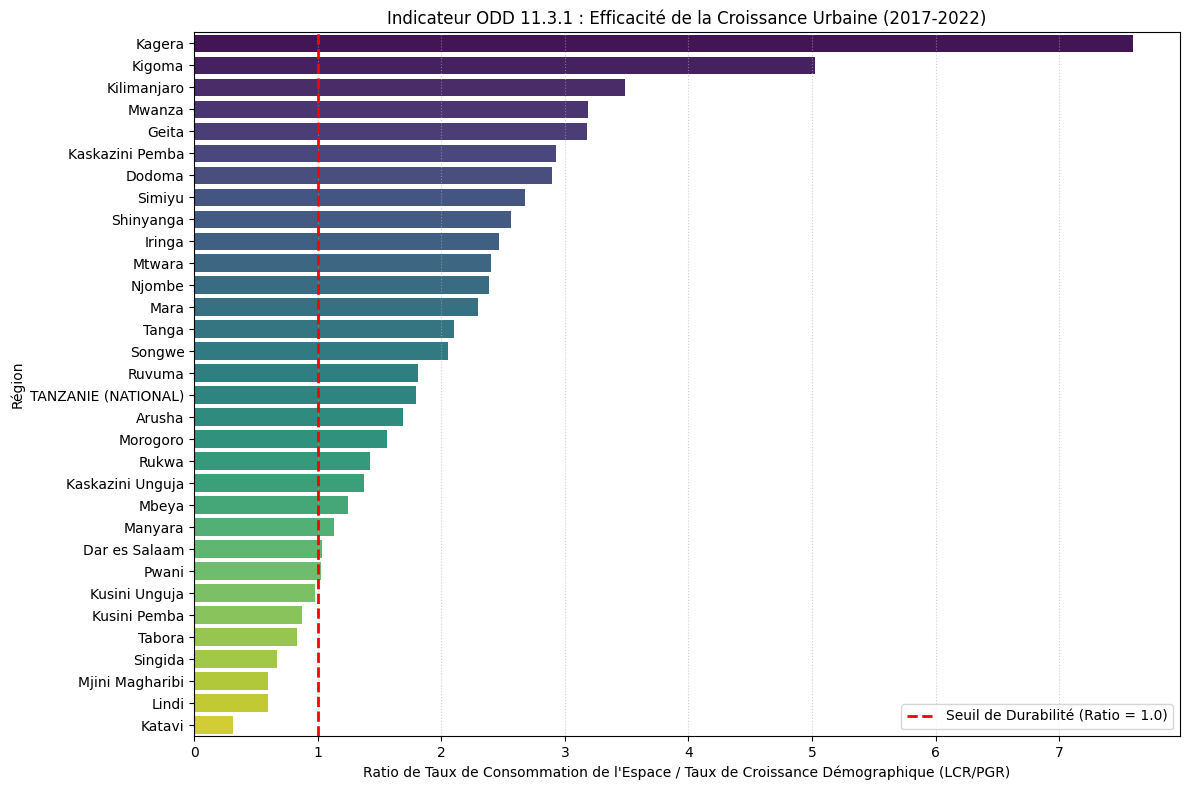


Analyse du Ratio LCR/PGR (Graphique 1) :
---------------------------------------
La ligne rouge à 1.0 indique l'équilibre :
 - Si la barre > 1.0 : L'étalement urbain (consommation d'espace) est plus rapide que la croissance démographique (Développement non durable).
 - Si la barre < 1.0 : La croissance démographique est plus rapide que l'étalement urbain (Développement plus efficace).


In [57]:
# =========================================================================
# SCRIPT DE VISUALISATION (MATPLOTLIB/SEABORN)
# =========================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("Génération des visualisations...")
print("-" * 80)

# --- Préparation des données ---
# S'assurer que df_complet est trié et filtré pour l'affichage régional
# Exclure la ligne "Tanzanie (Nationale)" pour les graphiques régionaux
df_regions_plot = df_complet[df_complet['Région'] != 'Tanzanie (Nationale)'].copy()
df_regions_plot = df_regions_plot.sort_values(by='LCRPGR', ascending=False)

# Convertir les taux en pourcentages annuels pour une meilleure lisibilité dans le graphique 2
df_regions_plot['LCR (%)'] = df_regions_plot['LCR'] * 100
df_regions_plot['PGR (%)'] = df_regions_plot['PGR'] * 100


# =================================================================
# GRAPHIQUE 1 : Ratio LCR/PGR par Région (Indicateur ODD 11.3.1)
# =================================================================

plt.figure(figsize=(12, 8))
sns.barplot(x='LCRPGR', y='Région', data=df_regions_plot, palette='viridis')

# Ligne de référence : Le seuil de durabilité est 1.0 (LCR = PGR)
plt.axvline(1.0, color='red', linestyle='--', linewidth=2, label='Seuil de Durabilité (Ratio = 1.0)')

plt.xlabel('Ratio de Taux de Consommation de l\'Espace / Taux de Croissance Démographique (LCR/PGR)')
plt.title(f"Indicateur ODD 11.3.1 : Efficacité de la Croissance Urbaine ({ANNEE_DEBUT}-{ANNEE_FIN})")
plt.legend()
plt.grid(axis='x', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# Interprétation du Graphique 1
print("\nAnalyse du Ratio LCR/PGR (Graphique 1) :")
print("---------------------------------------")
print("La ligne rouge à 1.0 indique l'équilibre :")
print(" - Si la barre > 1.0 : L'étalement urbain (consommation d'espace) est plus rapide que la croissance démographique (Développement non durable).")
print(" - Si la barre < 1.0 : La croissance démographique est plus rapide que l'étalement urbain (Développement plus efficace).")


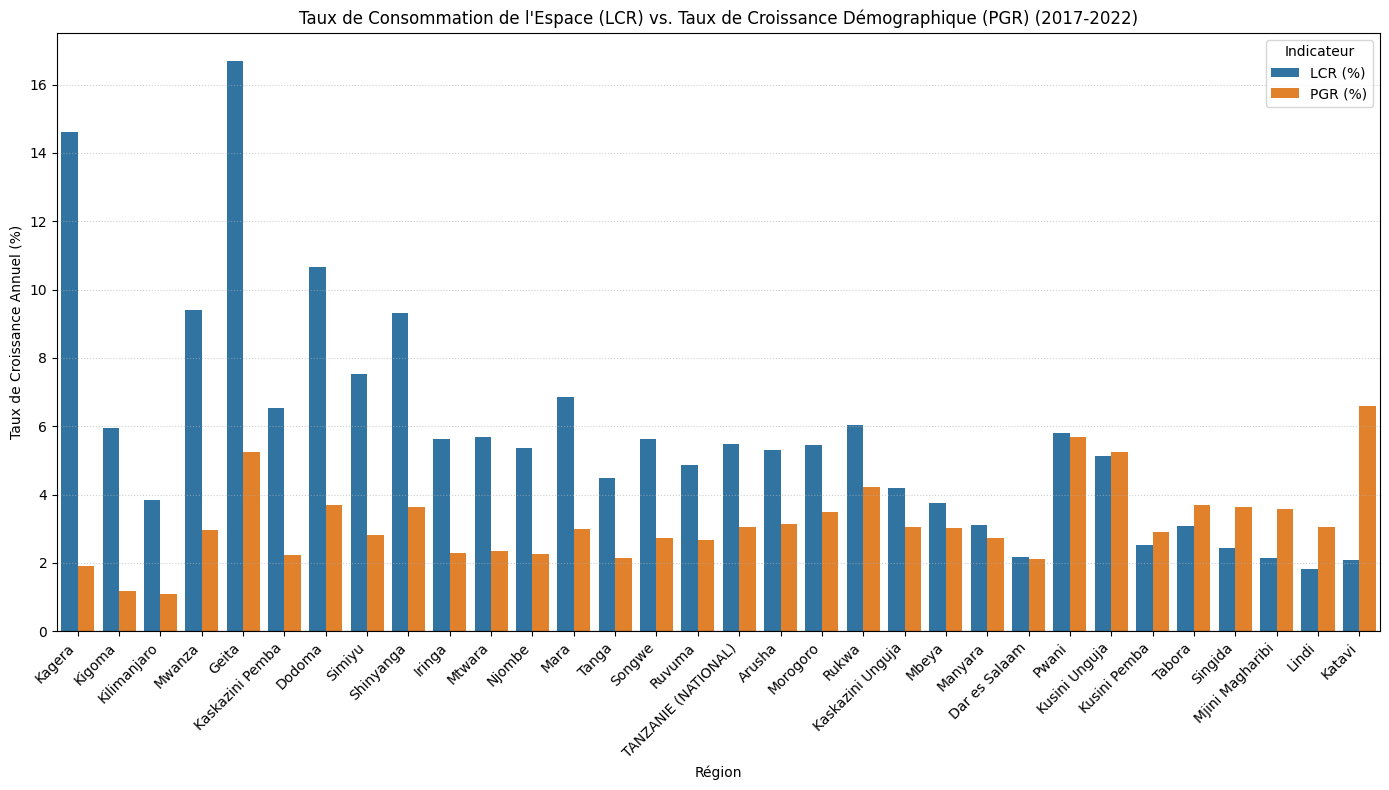


Analyse Contextuelle (Graphique 2) :
----------------------------------
 - LCR (Consommation d'espace) : Le taux annuel d'augmentation de la superficie bâtie.
 - PGR (Croissance Démographique) : Le taux annuel d'augmentation de la population.
Ce graphique permet de voir quelles régions connaissent la plus forte croissance globale (LCR et PGR élevés) et de visualiser l'écart entre les deux taux.


In [58]:


# =================================================================
# GRAPHIQUE 2 : Comparaison LCR vs. PGR (Taux en % annuel)
# =================================================================
# Ceci donne le contexte de la croissance totale des régions

df_melted = pd.melt(df_regions_plot, id_vars='Région', value_vars=['LCR (%)', 'PGR (%)'],
                    var_name='Taux', value_name='Valeur')

plt.figure(figsize=(14, 8))
sns.barplot(x='Région', y='Valeur', hue='Taux', data=df_melted, palette=['#1f77b4', '#ff7f0e'])

plt.axhline(0, color='black', linewidth=0.8) # Ligne à zéro
plt.xticks(rotation=45, ha='right')
plt.xlabel('Région')
plt.ylabel('Taux de Croissance Annuel (%)')
plt.title(f"Taux de Consommation de l'Espace (LCR) vs. Taux de Croissance Démographique (PGR) ({ANNEE_DEBUT}-{ANNEE_FIN})")
plt.legend(title='Indicateur')
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

print("\nAnalyse Contextuelle (Graphique 2) :")
print("----------------------------------")
print(" - LCR (Consommation d'espace) : Le taux annuel d'augmentation de la superficie bâtie.")
print(" - PGR (Croissance Démographique) : Le taux annuel d'augmentation de la population.")
print("Ce graphique permet de voir quelles régions connaissent la plus forte croissance globale (LCR et PGR élevés) et de visualiser l'écart entre les deux taux.")

In [72]:
# =========================================================================
# CARTE INTERACTIVE COMPLÈTE - RATIO LCRPGR
# (Panel National, Barre de Recherche, Tooltip Survol, Popup Clic)
# =========================================================================

import folium
import branca.colormap as cm
from folium.plugins import Search
# Assurez-vous d'avoir exécuté: !pip install folium branca

print("="*80)
print("CARTE INTERACTIVE COMPLÈTE - RATIO LCRPGR")
print("="*80)

# -------------------------------------------------------------------------
# 1. PRÉPARATION ET STYLE (Les données regions_geojson sont supposées chargées)
# -------------------------------------------------------------------------

print("\n1. Définition du style et de l'échelle de couleurs...")

# Récupérer toutes les valeurs LCRPGR valides
lcrpgr_values = [f['properties']['LCRPGR'] for f in regions_geojson['features']
                 if f['properties']['LCRPGR'] is not None]

# --- 1.1 Échelle de couleurs ---
if lcrpgr_values:
    min_val = min(lcrpgr_values)
    max_val = max(lcrpgr_values)

    # Création de l'échelle de couleurs (colormap)
    colormap = cm.LinearColormap(
        colors=['green', 'yellow', 'red'],
        vmin=min(0, min_val),
        vmax=max(2, max_val),
        caption='Ratio ODD 11.3.1 (LCRPGR)'
    )
    print(f"  • Échelle : {min_val:.2f} à {max_val:.2f}")
else:
    colormap = None
    print("  • Aucune donnée LCRPGR trouvée pour la carte.")

# --- 1.2 Fonction de style des régions ---
def style_function(feature):
    """Style conditionnel basé sur le ratio LCRPGR"""
    lcrpgr = feature['properties']['LCRPGR']

    if lcrpgr is None:
        return {
            'fillColor': '#CCCCCC',
            'color': '#666666',
            'weight': 1,
            'fillOpacity': 0.5,
            'dashArray': '5, 5'
        }
    elif colormap:
        return {
            'fillColor': colormap(lcrpgr),
            'color': '#333333',
            'weight': 1.5,
            'fillOpacity': 0.7
        }
    else:
        return {
            'fillColor': '#1f77b4',
            'color': '#333333',
            'weight': 1.5,
            'fillOpacity': 0.7
        }

# -------------------------------------------------------------------------
# 2. CRÉATION DE LA CARTE ET DES COUCHES
# -------------------------------------------------------------------------

print("\n2. Création de la carte et des couches...")

# Centre de la Tanzanie
center_lat = -6.3690
center_lon = 34.8888

# Créer la carte de base
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=6,
    tiles='CartoDB positron',
    control_scale=True
)

# Ajout de l'échelle de couleurs à la carte
if colormap:
    colormap.add_to(m)

# --- 2.1 Définition du POPUP pour l'affichage au CLIC ---
popup = folium.GeoJsonPopup(
    fields=['NAME_1', 'LCRPGR',
            f'V_{ANNEE_DEBUT}', f'V_{ANNEE_FIN}',
            f'Pop_{ANNEE_DEBUT}', f'Pop_{ANNEE_FIN}'],
    aliases=[
        'Région:',
        'Ratio ODD 11.3.1:',
        f'Surf. bâtie {ANNEE_DEBUT} (km²):',
        f'Surf. bâtie {ANNEE_FIN} (km²):',
        f'Population {ANNEE_DEBUT} (hab.):',
        f'Population {ANNEE_FIN} (hab.):'
    ],
    localize=True,
    labels=True,
    max_width=300
)

# --- 2.2 Création de la couche GeoJSON ---
geojson_layer = folium.GeoJson(
    regions_geojson,
    style_function=style_function,
    name='Régions de Tanzanie',

    # Tooltip pour le SURVOL (Nom et Ratio seulement)
    tooltip=folium.GeoJsonTooltip(
        fields=['NAME_1', 'LCRPGR'],
        aliases=['Région:', 'Ratio ODD 11.3.1:'],
        localize=True,
        style=("background-color: white; color: #333333; font-family: arial; "
               "font-size: 14px; padding: 5px; border-radius: 3px;"),
        max_width=150
    ),

    # Popup pour le CLIC (toutes les données)
    popup=popup,

    highlight_function=lambda x: {
        'weight': 3,
        'color': 'black',
        'fillOpacity': 0.9
    }
)

geojson_layer.add_to(m)

# -------------------------------------------------------------------------
# 3. BARRE DE RECHERCHE ET PANEL NATIONAL
# -------------------------------------------------------------------------

print("3. Ajout de la barre de recherche et du panel national...")

# --- 3.1 Barre de Recherche des Régions ---
Search(
    layer=geojson_layer,
    geom_type='polygon',
    placeholder="Rechercher une région...",
    collapsed=True,
    search_label='NAME_1', # Colonne utilisée pour la recherche (Nom de la région)
    search_zoom=8,
    position='topright'
).add_to(m)

# --- 3.2 Calculs pour le Panel National ---
delta_pop_national = national_Pop_2022 - national_Pop_2017
taux_pop_national = (delta_pop_national / national_Pop_2017 * 100) if national_Pop_2017 > 0 else 0
delta_v_national = national_V_2022 - national_V_2017
taux_v_national = (delta_v_national / national_V_2017 * 100) if national_V_2017 > 0 else 0

if not np.isnan(national_result['LCRPGR']):
    lcrpgr_formatted = f"{national_result['LCRPGR']:.2f}"
    # Détermination de la couleur et du texte
    if national_result['LCRPGR'] > 1.05:
        ratio_color = '#d9534f' # Rouge
        ratio_text = '⚠️ ÉTALEMENT URBAIN'
    elif national_result['LCRPGR'] < 0.95:
        ratio_color = '#5cb85c' # Vert
        ratio_text = '✓ DENSIFICATION'
    else:
        ratio_color = '#f0ad4e' # Jaune/Orange
        ratio_text = '⚖️ ÉQUILIBRE'
else:
    lcrpgr_formatted = "N/A"
    ratio_color = '#6c757d'
    ratio_text = 'DONNÉES MANQUANTES'


# --- 3.3 HTML pour le Panel d'informations ---
info_html = f"""
<div style="
    position: absolute;
    top: 10px;
    left: 10px;
    width: 350px;
    background-color: white;
    padding: 20px;
    border-radius: 8px;
    box-shadow: 0 4px 12px rgba(0,0,0,0.3);
    z-index: 1000;
    font-family: Arial, sans-serif;
    font-size: 13px;
    max-height: 90vh;
    overflow-y: auto;
    border: 2px solid #1a5276;
">
    <div style="text-align: center; margin-bottom: 15px;">
        <h2 style="margin: 0; color: #1a5276; font-size: 18px;">
            🌍 TANZANIE
        </h2>
        <p style="margin: 5px 0 0 0; color: #2e86c1; font-size: 14px;">
            Analyse ODD 11.3.1 ({ANNEE_DEBUT} → {ANNEE_FIN})
        </p>
    </div>

    <div style="margin-bottom: 20px; padding: 15px; background-color: #f8f9fa; border-radius: 5px; border-left: 4px solid #2e86c1;">
        <h3 style="color: #2e86c1; margin-top: 0; font-size: 15px; border-bottom: 1px solid #dee2e6; padding-bottom: 5px;">
            📊 INDICATEUR NATIONAL
        </h3>
        <div style="text-align: center; margin: 10px 0;">
            <div style="font-size: 28px; font-weight: bold; color: {ratio_color};">
                {lcrpgr_formatted}
            </div>
            <div style="font-size: 12px; color: #6c757d;">
                Ratio ODD 11.3.1 (LCR/PGR)
            </div>
        </div>
        <div style="font-size: 11px; text-align: center; margin-top: 5px;">
            <span style="color: {ratio_color}; font-weight: bold;">
                {ratio_text}
            </span>
        </div>
        <div style="font-size: 11px; text-align: center; margin-top: 5px; color: #6c757d;">
            LCR: {national_result['LCR']*100:.2f}%/an | PGR: {national_result['PGR']*100:.2f}%/an
        </div>
    </div>

    <div style="margin-bottom: 20px;">
        <h3 style="color: #2e86c1; margin-top: 0; font-size: 15px; border-bottom: 1px solid #dee2e6; padding-bottom: 5px;">
            📈 STATISTIQUES NATIONALES
        </h3>
        <table style="width: 100%; font-size: 12px; border-collapse: collapse;">
            <tr>
                <td style="padding: 6px; border-bottom: 1px solid #eee;">Superficie bâtie {ANNEE_DEBUT}:</td>
                <td style="padding: 6px; border-bottom: 1px solid #eee; text-align: right;">{national_V_2017:,.1f} km²</td>
            </tr>
            <tr>
                <td style="padding: 6px; border-bottom: 1px solid #eee;">Superficie bâtie {ANNEE_FIN}:</td>
                <td style="padding: 6px; border-bottom: 1px solid #eee; text-align: right;">{national_V_2022:,.1f} km²</td>
            </tr>
            <tr>
                <td style="padding: 6px; border-bottom: 1px solid #eee;">Croissance superficie:</td>
                <td style="padding: 6px; border-bottom: 1px solid #eee; text-align: right; font-weight: bold; color: {'green' if taux_v_national > 0 else 'red'};">
                    {delta_v_national:+,.1f} km² ({taux_v_national:+.1f}%)
                </td>
            </tr>
            <tr>
                <td style="padding: 6px; border-bottom: 1px solid #eee;">Population {ANNEE_DEBUT}:</td>
                <td style="padding: 6px; border-bottom: 1px solid #eee; text-align: right;">{national_Pop_2017:,.0f}</td>
            </tr>
            <tr>
                <td style="padding: 6px; border-bottom: 1px solid #eee;">Population {ANNEE_FIN}:</td>
                <td style="padding: 6px; border-bottom: 1px solid #eee; text-align: right;">{national_Pop_2022:,.0f}</td>
            </tr>
            <tr>
                <td style="padding: 6px;">Croissance population:</td>
                <td style="padding: 6px; text-align: right; font-weight: bold; color: {'green' if delta_pop_national > 0 else 'red'};">
                    {delta_pop_national:+,.0f} ({taux_pop_national:+.1f}%)
                </td>
            </tr>
        </table>
    </div>

    <div style="margin-bottom: 20px;">
        <h3 style="color: #2e86c1; margin-top: 0; font-size: 15px; border-bottom: 1px solid #dee2e6; padding-bottom: 5px;">
            🔍 COMMENT UTILISER
        </h3>
        <ul style="margin: 10px 0; padding-left: 20px; font-size: 12px;">
            <li><strong>Recherchez</strong> une région dans la barre en haut à droite.</li>
            <li><strong>Survolez</strong> une région pour voir le ratio LCRPGR.</li>
            <li><strong>Cliquez</strong> pour voir tous les détails de la région.</li>
        </ul>
    </div>

    <hr style="margin: 15px 0; border: none; border-top: 1px solid #ddd;">
    <div style="font-size: 11px; color: #6c757d; text-align: center; line-height: 1.4;">
        <strong>Indicateur ODD 11.3.1</strong> | Période: {ANNEE_DEBUT}-{ANNEE_FIN}<br>
        Ratio consommation des terres (LCR) vs croissance démographique (PGR)
    </div>
</div>
"""

# Ajouter le panel d'informations à la carte
m.get_root().html.add_child(folium.Element(info_html))

# -------------------------------------------------------------------------
# 4. SAUVEGARDE ET AFFICHAGE
# -------------------------------------------------------------------------

print("\n4. Sauvegarde de la carte...")

output_file = 'Carte_LCRPGR_Tanzanie_Complete.html'
m.save(output_file)

print(f"\n" + "="*80)
print("✅ CARTE COMPLÈTE CRÉÉE AVEC SUCCÈS")
print(f"📁 Fichier sauvegardé : {output_file}")

# Affichage dans le notebook (si applicable)
try:
    from IPython.display import display, HTML
    print(f"\n🔍 Affichage de l'aperçu...")
    display(HTML(m._repr_html_()))
except:
    print(f"\nℹ️  Pour visualiser la carte, ouvrez le fichier '{output_file}' dans un navigateur web.")

print("="*80)

CARTE INTERACTIVE COMPLÈTE - RATIO LCRPGR

1. Définition du style et de l'échelle de couleurs...
  • Échelle : 0.32 à 7.60

2. Création de la carte et des couches...
3. Ajout de la barre de recherche et du panel national...

4. Sauvegarde de la carte...

✅ CARTE COMPLÈTE CRÉÉE AVEC SUCCÈS
📁 Fichier sauvegardé : Carte_LCRPGR_Tanzanie_Complete.html

🔍 Affichage de l'aperçu...
